<h1> CREAZIONE MODELLO SARIMA GERMANIA

In [2]:
import pandas as pd
df = pd.read_csv('../../csv/nazioni/serie_storica_ge.csv')
df.head()

,TIME,GEO,Value
0,2016-01-11,Germany,18439
1,2016-01-18,Germany,18627
2,2016-01-25,Germany,18707
3,2016-02-01,Germany,18493
4,2016-02-08,Germany,18541


In [3]:
df['TIME'] = pd.to_datetime(df['TIME'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TIME    246 non-null    datetime64[ns]
 1   GEO     246 non-null    object        
 2   Value   246 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 5.9+ KB


In [5]:
df=df.set_index('TIME')
df.head()

,GEO,Value
TIME,,
2016-01-11,Germany,18439
2016-01-18,Germany,18627
2016-01-25,Germany,18707
2016-02-01,Germany,18493
2016-02-08,Germany,18541


<h3>Creazione serie storica dei decessi totali

In [7]:
df = df.groupby(pd.Grouper(freq='M')).sum()
df.head()

,Value
TIME,
2016-01-31,55773
2016-02-29,92918
2016-03-31,75302
2016-04-30,69784
2016-05-31,83763


In [8]:
ts = df.Value
ts.head()

TIME
2016-01-31    55773
2016-02-29    92918
2016-03-31    75302
2016-04-30    69784
2016-05-31    83763
Freq: M, Name: Value, dtype: int64

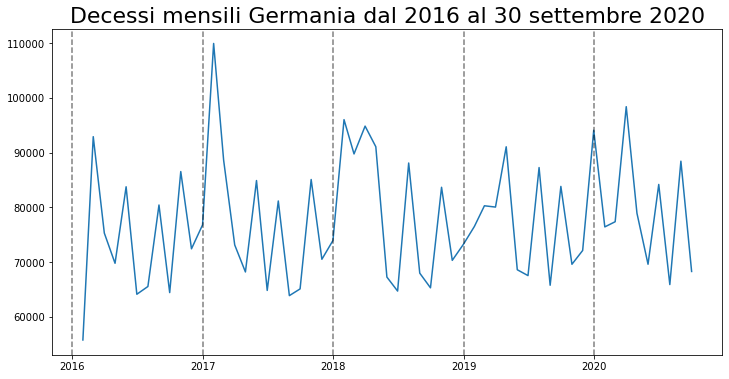

In [12]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2016,1,1)
end_date = datetime(2020,9,30)
lim_ts = ts[start_date:end_date]

#visulizzo il grafico
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi mensili Germania dal 2016 al 30 settembre 2020', size=22)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h3>Decomposizione

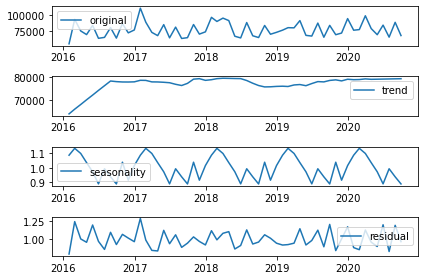

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

<h3>Test di stazionarietà

In [14]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False
        

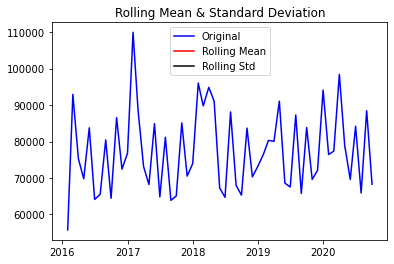

Results of Dickey-Fuller Test:
Test Statistic                -8.478693e+00
p-value                        1.412335e-13
#Lags Used                     0.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64
X is stationary


True

In [15]:
test_stationarity(ts)

<h3>Suddivisione in Train e Test

<b>Train</b>: da gennaio 2016 a ottobre 2019; <br />
<b>Test</b>: da ottobre 2019 a dicembre 2019.

In [16]:
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,8,30)


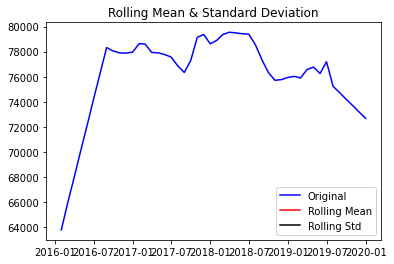

Results of Dickey-Fuller Test:
Test Statistic                 -3.123555
p-value                         0.024858
#Lags Used                      1.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64
X is not stationary


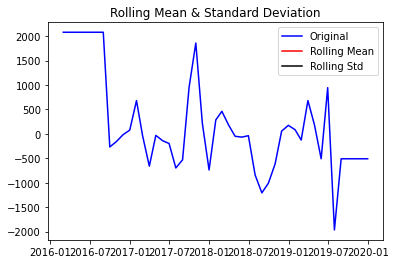

Results of Dickey-Fuller Test:
Test Statistic                 -3.367718
p-value                         0.012110
#Lags Used                      0.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64
X is not stationary


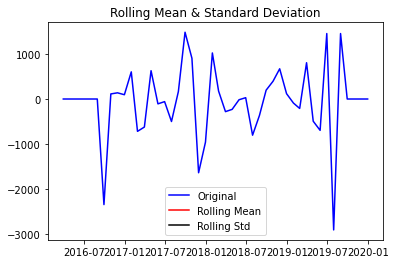

Results of Dickey-Fuller Test:
Test Statistic                 -5.370573
p-value                         0.000004
#Lags Used                      2.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64
X is stationary
2


In [17]:
from dateutil.relativedelta import *
tsb = ts[:test_end]
decomposition = seasonal_decompose(tsb, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

tsb_trend = decomposition.trend #andamento della curva
tsb_seasonal = decomposition.seasonal #stagionalità 
tsb_residual = decomposition.resid #parti rimanenti


tsb_diff = pd.Series(tsb_trend)
d = 0
while test_stationarity(tsb_diff) is False:
    tsb_diff = tsb_diff.diff().dropna()
    d = d + 1
print(d)

#TEST: dal 01-01-2015 al 31-10-2019
train = tsb[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = tsb[train_end + relativedelta(months=+1): test_end]

<h3>Grafici di Autocorrelazione e Autocorrelazione Parziale

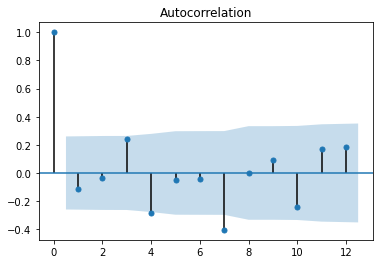

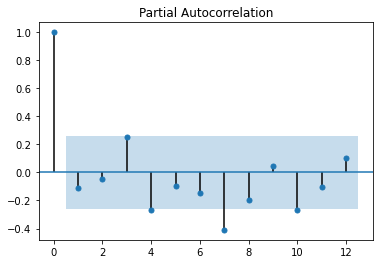

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

<h2>Creazione del modello SARIMA sul Train

In [143]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(6,0,8))
model_fit = model.fit()
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   46
Model:               SARIMAX(6, 0, 8)   Log Likelihood                -493.308
Date:                Sat, 12 Dec 2020   AIC                           1016.616
Time:                        17:53:20   BIC                           1044.046
Sample:                    01-31-2016   HQIC                          1026.891
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4979      0.397     -1.255      0.210      -1.276       0.280
ar.L2         -0.3299      0.230     -1.435      0.151      -0.781       0.121
ar.L3          0.1013      0.270      0.374      0.7

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<h4>Verifica della stazionarietà dei residui del modello ottenuto

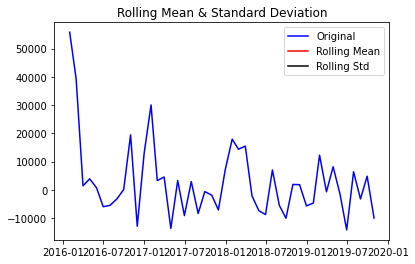

Results of Dickey-Fuller Test:
Test Statistic                -6.125908e+00
p-value                        8.630558e-08
#Lags Used                     0.000000e+00
Number of Observations Used    4.500000e+01
Critical Value (1%)           -3.584829e+00
Critical Value (5%)           -2.928299e+00
Critical Value (10%)          -2.602344e+00
dtype: float64
X is stationary


True

In [144]:
residuals = model_fit.resid
test_stationarity(residuals)

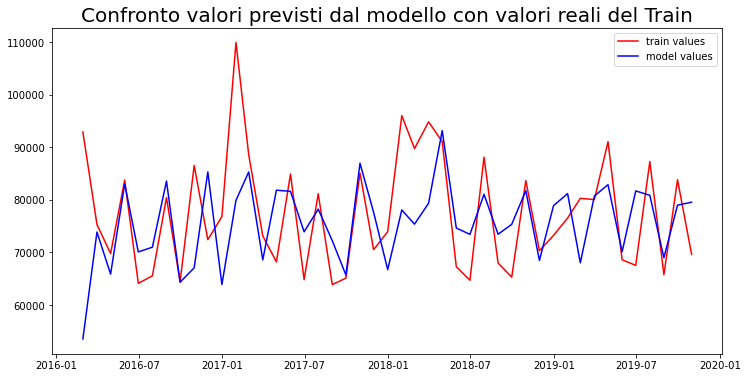

In [145]:
plt.figure(figsize=(12,6))
plt.title('Confronto valori previsti dal modello con valori reali del Train', size=20)
plt.plot (train.iloc[1:], color='red', label='train values')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue', label='model values')

plt.legend()
plt.show()


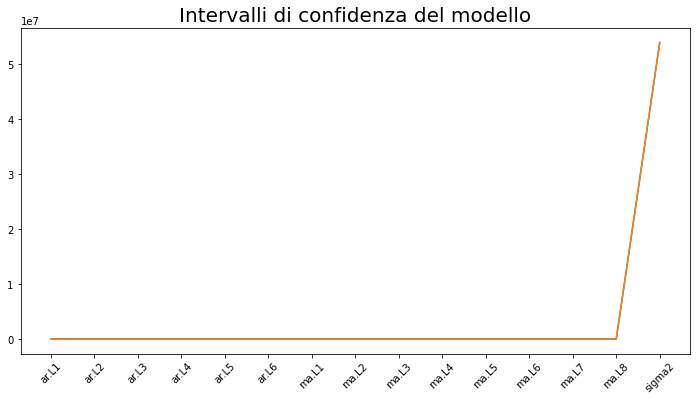

In [146]:
conf = model_fit.conf_int()

plt.figure(figsize=(12,6))
plt.title('Intervalli di confidenza del modello', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

<h3>Predizione del modello sul Test

In [147]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]

print(pred_end)
print(pred_start)

2019-12-31 00:00:00
2019-11-30 00:00:00


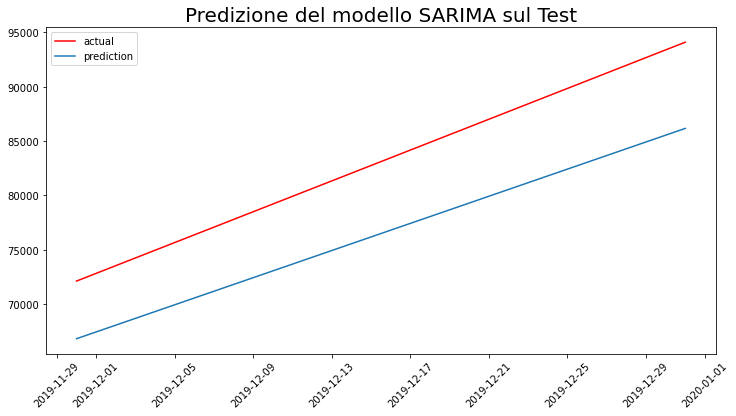

2019-11-30    66823.178975
2019-12-31    86163.053426
Freq: M, Name: predicted_mean, dtype: float64


In [148]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]


#predizione del modello sul test
predictions_test= model_fit.predict(start=pred_start, end=pred_end)


plt.figure(figsize=(12,6))
plt.title('Predizione del modello SARIMA sul Test', size=20)
plt.plot(test, color='red', label='actual')
plt.plot(predictions_test, label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(predictions_test)

<h3>Calcolo dell'indice RMSE

In [149]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.30698565915787845


<h2>Predizione del modello compreso l'anno 2020

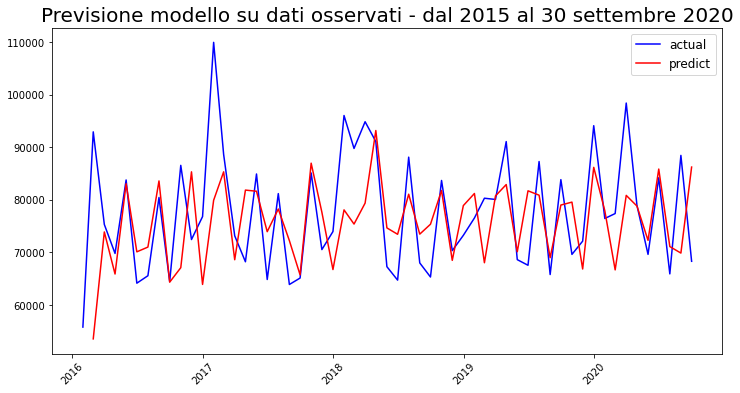

In [150]:
#inizio e fine predizione
start_prediction = ts.index[0]
end_prediction = ts.index[-1]

predictions_tot = model_fit.predict(start=start_prediction, end=end_prediction)

plt.figure(figsize=(12,6))
plt.title('Previsione modello su dati osservati - dal 2015 al 30 settembre 2020', size=20)
plt.plot(ts, color='blue', label='actual')
plt.plot(predictions_tot.iloc[1:], color='red', label='predict')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

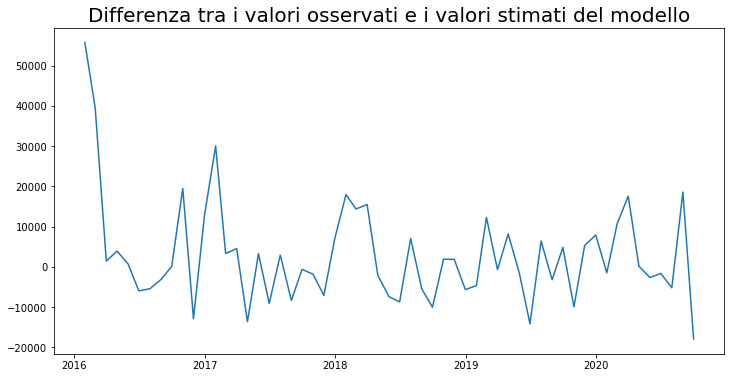

In [151]:
diff_predictions_tot = (ts - predictions_tot)
plt.figure(figsize=(12,6))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot)
plt.show()

In [152]:
diff_predictions_tot['24-02-2020':].sum()

19560.11977666976

In [153]:
predictions_tot.to_csv('../../csv/pred/predictions_SARIMA_ge.csv')

<h2>Intervalli di confidenza della previsione totale

In [154]:
forecast = model_fit.get_prediction(start=start_prediction, end=end_prediction)
in_c = forecast.conf_int()
print(forecast.predicted_mean)
print(in_c)
print(forecast.predicted_mean - in_c['lower Value'])

2016-01-31        0.000000
2016-02-29    53529.687352
2016-03-31    73876.881254
2016-04-30    65870.777044
2016-05-31    83051.338923
2016-06-30    70091.205458
2016-07-31    70995.600439
2016-08-31    83580.630773
2016-09-30    64325.224747
2016-10-31    67071.852315
2016-11-30    85312.383332
2016-12-31    63889.374084
2017-01-31    79899.741925
2017-02-28    85314.531552
2017-03-31    68587.546486
2017-04-30    81838.935514
2017-05-31    81620.138611
2017-06-30    73925.202557
2017-07-31    78240.441437
2017-08-31    72228.848821
2017-09-30    65708.297459
2017-10-31    86958.886964
2017-11-30    77627.660502
2017-12-31    66719.192856
2018-01-31    78073.638192
2018-02-28    75374.147827
2018-03-31    79360.732802
2018-04-30    93174.608069
2018-05-31    74643.680589
2018-06-30    73429.813825
2018-07-31    81055.253134
2018-08-31    73460.220563
2018-09-30    75341.883046
2018-10-31    81756.142475
2018-11-30    68469.645503
2018-12-31    78892.210406
2019-01-31    81189.409720
2

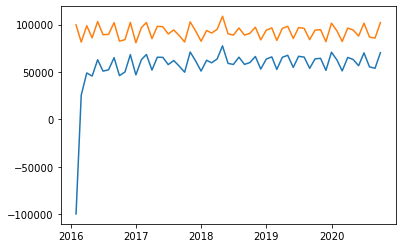

In [155]:
plt.plot(in_c)
plt.show()

In [156]:
upper = in_c['upper Value']
lower = in_c['lower Value']

In [157]:
lower.to_csv('../../csv/lower/predictions_SARIMA_ge_lower.csv')
upper.to_csv('../../csv/upper/predictions_SARIMA_ge_upper.csv')